In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the datasets
adata_spatial1 = sc.read_h5ad('./spatial1_annotated.h5ad')
adata_spatial3 = sc.read_h5ad('./spatial3_annotated.h5ad')

In [4]:
adata_spatial1

AnnData object with n_obs × n_vars = 4917 × 14912
    obs: 'in_tissue', 'array_row', 'array_col', 'Trimester', 'Sample', 'Gestation', 'Code', 'Batch', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'cell_type', 'unique_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'Gestation_colors', 'Sample_colors', 'cell_type_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_spatial_First_tri_1', 'X_spatial_First_tri_2', 'X_spatial_First_tri_3', 'X_spatial_Merged', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata_spatial3

AnnData object with n_obs × n_vars = 17539 × 16134
    obs: 'in_tissue', 'array_row', 'array_col', 'Trimester', 'Sample', 'Pathology', 'Sex', 'Gestation', 'Centile', 'Delivery', 'BMI', 'Mat_age', 'Code', 'Batch', 'Batch2', 'Pathology2', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'Gestation2', 'n_genes', 'leiden', 'leiden_1', 'leiden_2', 'leiden_1.5', 'cell_type', 'unique_cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Delivery_colors', 'Gestation2_colors', 'Gestation_colors', 'Pathology_colors', 'Sample_colors', 'Sex_colors', 'dendrogram_Sample', 'hvg', 'leiden', 'leiden_1', 'leiden_1.5', 'leiden_1.5_colors', 'leiden_1_colors', 'leiden_2', 'leiden_2_colors', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'spatial', 'umap', 'wilcoxon_c

In [3]:
# Undo log1p (for both datasets)
adata_spatial1.X = np.expm1(adata_spatial1.X)
adata_spatial3.X = np.expm1(adata_spatial3.X)

# Clear the log1p flag
adata_spatial1.uns.pop('log1p', None)
adata_spatial3.uns.pop('log1p', None)

{}

In [4]:
# Remove genes with all zeros in each dataset
# This will keep genes that are expressed in at least one cell
adata_spatial1 = adata_spatial1[:, np.asarray((adata_spatial1.X > 0).sum(axis=0)).flatten() > 0]
adata_spatial3 = adata_spatial3[:, np.asarray((adata_spatial3.X > 0).sum(axis=0)).flatten() > 0]

In [5]:
adata_spatial1.obs['Pathology'] = 'Control'

/tmp/ipykernel_246717/415707543.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_spatial1.obs['Pathology'] = 'Control'


In [6]:
# Concatenate datasets
adata = ad.concat([adata_spatial1, adata_spatial3], join='inner',index_unique='_')

In [7]:
import scipy.sparse as sp

# Compute total counts per cell
if sp.issparse(adata.X):
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
else:
    total_counts = adata.X.sum(axis=1)

# Compute summary statistics
print(f"Min: {total_counts.min():.2f}")
print(f"Max: {total_counts.max():.2f}")
print(f"Mean: {total_counts.mean():.2f}")
print(f"Median: {np.median(total_counts):.2f}")
print(f"Std Dev: {total_counts.std():.2f}")

Min: 4816.23
Max: 6511.00
Mean: 5214.60
Median: 4852.11
Std Dev: 686.05


In [8]:
# Normalize with a fixed target_sum (to ensure comparability)
sc.pp.normalize_total(adata, target_sum=1e4)

In [9]:
# Compute total counts per cell
if sp.issparse(adata.X):
    total_counts = np.array(adata.X.sum(axis=1)).flatten()
else:
    total_counts = adata.X.sum(axis=1)

# Compute summary statistics
print(f"Min: {total_counts.min():.2f}")
print(f"Max: {total_counts.max():.2f}")
print(f"Mean: {total_counts.mean():.2f}")
print(f"Median: {np.median(total_counts):.2f}")
print(f"Std Dev: {total_counts.std():.2f}")

Min: 9999.99
Max: 10000.00
Mean: 10000.00
Median: 10000.00
Std Dev: 0.00


In [10]:
sc.pp.log1p(adata)

In [11]:
adata

AnnData object with n_obs × n_vars = 22456 × 14781
    obs: 'in_tissue', 'array_row', 'array_col', 'Trimester', 'Sample', 'Gestation', 'Code', 'Batch', 'n_genes_by_counts', 'total_counts', 'n_genes', 'leiden', 'cell_type', 'unique_cell_type', 'Pathology'
    uns: 'log1p'
    obsm: 'X_pca', 'X_pca_harmony', 'X_spatial_Merged', 'X_umap', 'spatial'

#### Check housekeeping genes ####

In [12]:
# Define housekeeping genes (common ones found in most datasets)
housekeeping_genes = [
    # Ribosomal proteins
    'RPL13A', 'RPS18', 'RPL32', 'RPS27A', 'RPL19', 'RPS13',
    
    # Glycolysis/metabolism
    'GAPDH', 'ACTB', 'TUBB', 'LDHA', 'ENO1', 'PKM',
    
    # Protein synthesis/processing
    'EEF1A1', 'EIF4A1', 'HSP90AA1', 'HSPA8',
    
    # DNA/RNA processing
    'POLR2A', 'TOP1', 'PCNA',
    
    # Other common housekeepers
    'B2M', 'HPRT1', 'TBP', 'YWHAZ', 'UBC'
]

# Check which housekeeping genes are present in your dataset
available_hk_genes = [gene for gene in housekeeping_genes if gene in adata.var_names]
print(f"Available housekeeping genes: {available_hk_genes}")
print(f"Missing genes: {set(housekeeping_genes) - set(available_hk_genes)}")

Available housekeeping genes: ['ACTB', 'ENO1', 'EIF4A1', 'HSP90AA1', 'HSPA8', 'POLR2A', 'TOP1', 'PCNA', 'B2M', 'HPRT1', 'TBP', 'UBC']
Missing genes: {'YWHAZ', 'GAPDH', 'RPS27A', 'RPL32', 'TUBB', 'PKM', 'EEF1A1', 'RPL19', 'RPL13A', 'LDHA', 'RPS18', 'RPS13'}


In [13]:
# Function to compare housekeeping genes between trimesters
def compare_housekeeping_expression(adata, hk_genes, groupby='Trimester'):
    """
    Compare housekeeping gene expression between groups
    """
    # Create dataframe for housekeeping gene expression
    hk_expr_data = []
    
    for group in adata.obs[groupby].unique():
        group_mask = adata.obs[groupby] == group
        group_cells = adata[group_mask, :]
        
        for gene in hk_genes:
            if gene in adata.var_names:
                mean_expr = np.mean(group_cells[:, gene].X.toarray().flatten())
                std_expr = np.std(group_cells[:, gene].X.toarray().flatten())
                median_expr = np.median(group_cells[:, gene].X.toarray().flatten())
                
                hk_expr_data.append({
                    'gene': gene,
                    'group': group,
                    'mean_expression': mean_expr,
                    'std_expression': std_expr,
                    'median_expression': median_expr,
                    'n_cells': group_mask.sum()
                })
    
    return pd.DataFrame(hk_expr_data)

# Get housekeeping gene expression data
hk_df = compare_housekeeping_expression(adata, available_hk_genes)
print(hk_df)

        gene  group  mean_expression  std_expression  median_expression  \
0       ACTB  First         3.247270        0.637712           3.342539   
1       ENO1  First         1.658612        0.855850           1.732085   
2     EIF4A1  First         1.838126        0.716103           1.993496   
3   HSP90AA1  First         2.751181        1.029568           3.012208   
4      HSPA8  First         2.540668        0.924376           2.764398   
5     POLR2A  First         0.515402        0.591477           0.000000   
6       TOP1  First         1.020959        0.716112           1.170255   
7       PCNA  First         0.437193        0.567442           0.000000   
8        B2M  First         1.813452        0.766912           1.932994   
9      HPRT1  First         0.085143        0.278044           0.000000   
10       TBP  First         0.061420        0.225513           0.000000   
11       UBC  First         4.267153        0.402188           4.253246   
12      ACTB  Third      

#### Batch correction ####

In [14]:
sc.pp.combat(adata, key='Trimester')

In [15]:
adata.write('spatialmerged_07.07.h5ad') 

In [2]:
adata = sc.read_h5ad('./spatialmerged_07.07.h5ad')

#### Check housekeeping genes again ####

In [16]:
# Function to compare housekeeping genes between trimesters
def compare_housekeeping_expression(adata, hk_genes, groupby='Trimester'):
    """
    Compare housekeeping gene expression between groups
    """
    # Create dataframe for housekeeping gene expression
    hk_expr_data = []
    
    for group in adata.obs[groupby].unique():
        group_mask = adata.obs[groupby] == group
        group_cells = adata[group_mask, :]
        
        for gene in hk_genes:
            if gene in adata.var_names:
                mean_expr = np.mean(group_cells[:, gene].X.toarray().flatten())
                std_expr = np.std(group_cells[:, gene].X.toarray().flatten())
                median_expr = np.median(group_cells[:, gene].X.toarray().flatten())
                
                hk_expr_data.append({
                    'gene': gene,
                    'group': group,
                    'mean_expression': mean_expr,
                    'std_expression': std_expr,
                    'median_expression': median_expr,
                    'n_cells': group_mask.sum()
                })
    
    return pd.DataFrame(hk_expr_data)

# Get housekeeping gene expression data
hk_df = compare_housekeeping_expression(adata, available_hk_genes)
print(hk_df)

        gene  group  mean_expression  std_expression  median_expression  \
0       ACTB  First         3.304951        0.620005           3.397575   
1       ENO1  First         1.128751        0.803736           1.197750   
2     EIF4A1  First         1.837424        0.769121           2.004297   
3   HSP90AA1  First         2.235029        0.833701           2.446398   
4      HSPA8  First         2.273494        0.801430           2.467466   
5     POLR2A  First         0.514008        0.630885          -0.035734   
6       TOP1  First         1.043385        0.770268           1.203972   
7       PCNA  First         0.400688        0.576666          -0.043613   
8        B2M  First         2.355702        0.782922           2.477739   
9      HPRT1  First         0.097086        0.308785           0.002530   
10       TBP  First         0.073311        0.269961          -0.000214   
11       UBC  First         4.125531        0.405555           4.111506   
12      ACTB  Third      

#### First vs Third Heatmap ####

In [3]:
mitocarta = pd.read_csv("../MitoCarta_full_transformed.csv")

In [4]:
# Extract all unique mitochondrial genes
mt_list = mitocarta['Gene'].unique().tolist()
len(mt_list)

1136

In [5]:
# Create boolean column for mitochondrial genes
adata.var['mito_gene'] = adata.var_names.map(lambda x: x.split('.')[0] in mt_list)
adata.var['mito_gene'].sum()

939

In [6]:
missing_genes = [gene for gene in mt_list if gene not in adata.var_names]
missing_genes

['ATAD3A',
 'ATAD3B',
 'GARS1',
 'KARS1',
 'METTL15',
 'METTL5',
 'MPV17L2',
 'MRPL1',
 'MRPL10',
 'MRPL11',
 'MRPL12',
 'MRPL13',
 'MRPL14',
 'MRPL15',
 'MRPL16',
 'MRPL17',
 'MRPL18',
 'MRPL19',
 'MRPL2',
 'MRPL20',
 'MRPL21',
 'MRPL22',
 'MRPL23',
 'MRPL24',
 'MRPL27',
 'MRPL28',
 'MRPL3',
 'MRPL30',
 'MRPL32',
 'MRPL33',
 'MRPL34',
 'MRPL35',
 'MRPL36',
 'MRPL37',
 'MRPL38',
 'MRPL39',
 'MRPL4',
 'MRPL40',
 'MRPL41',
 'MRPL42',
 'MRPL43',
 'MRPL44',
 'MRPL45',
 'MRPL46',
 'MRPL47',
 'MRPL48',
 'MRPL49',
 'MRPL50',
 'MRPL51',
 'MRPL52',
 'MRPL53',
 'MRPL54',
 'MRPL55',
 'MRPL57',
 'MRPL58',
 'MRPL9',
 'MRPS10',
 'MRPS11',
 'MRPS12',
 'MRPS14',
 'MRPS15',
 'MRPS16',
 'MRPS17',
 'MRPS18A',
 'MRPS18B',
 'MRPS18C',
 'MRPS2',
 'MRPS21',
 'MRPS22',
 'MRPS23',
 'MRPS24',
 'MRPS25',
 'MRPS26',
 'MRPS27',
 'MRPS28',
 'MRPS30',
 'MRPS31',
 'MRPS33',
 'MRPS34',
 'MRPS35',
 'MRPS36',
 'MRPS5',
 'MRPS6',
 'MRPS7',
 'MRPS9',
 'MYG1',
 'PNPT1',
 'PTCD3',
 'TFAM',
 'TRMT1',
 'PMPCA',
 'TOMM20L',
 '

In [7]:
len(missing_genes)

197

In [8]:
# Create a dictionary where each gene maps to a list of pathways
gene_to_pathway_dict = mitocarta.groupby('Gene')['MitoPathway'].apply(list).to_dict()

# Add pathway information to the var metadata 
adata.var['MitoPathways'] = adata.var_names.map(lambda x: gene_to_pathway_dict.get(x.split('.')[0], []))
# Check the result
adata.var[['MitoPathways']].head()

,MitoPathways
SAMD11,[]
NOC2L,[]
KLHL17,[]
PLEKHN1,[]
PERM1,[]


In [9]:
# Check that no genes are all zeros in either trimester
first_mask = adata.obs['Trimester'] == 'First'
third_mask = adata.obs['Trimester'] == 'Third'

# Count genes with zero expression in each trimester
first_zero_genes = (adata[first_mask].X.sum(axis=0) == 0).sum()
third_zero_genes = (adata[third_mask].X.sum(axis=0) == 0).sum()

print(f"Genes with zero expression in First trimester: {first_zero_genes}")
print(f"Genes with zero expression in Third trimester: {third_zero_genes}")
print(f"Total genes in combined dataset: {adata.n_vars}")

Genes with zero expression in First trimester: 0
Genes with zero expression in Third trimester: 0
Total genes in combined dataset: 14781


In [10]:
pathway_names = ["OXPHOS", "OXPHOS_subunits", "OXPHOS_assembly_factors", "Complex_I", "CI_subunits", "CI_assembly_factors", 
                 "Complex_II", "CII_subunits", "CII_assembly_factors",
                 "Complex_III", "CIII_subunits", "CIII_assembly_factors",
                 "Complex_IV", "CIV_subunits", "CIV_assembly_factors",
                 "Complex_V", "CV_subunits", "CV_assembly_factors",
                 "Respirasome_assembly", "Cytochrome_C"]

In [11]:
# Extract genes for each pathway
## create a dictionary where each key is a pathway name and each value is a list of genes associated with that pathway 
## finds genes in adata with the 'MitoPathways' annotation
pathway_genes = {}
for pathway in pathway_names:
    pathway_genes[pathway] = adata.var[adata.var['MitoPathways'].apply(lambda x: pathway in x)].index.tolist()
    print(f"Found {len(pathway_genes[pathway])} genes for {pathway}")

Found 136 genes for OXPHOS
Found 76 genes for OXPHOS_subunits
Found 61 genes for OXPHOS_assembly_factors
Found 53 genes for Complex_I
Found 32 genes for CI_subunits
Found 21 genes for CI_assembly_factors
Found 5 genes for Complex_II
Found 3 genes for CII_subunits
Found 2 genes for CII_assembly_factors
Found 13 genes for Complex_III
Found 7 genes for CIII_subunits
Found 6 genes for CIII_assembly_factors
Found 44 genes for Complex_IV
Found 17 genes for CIV_subunits
Found 27 genes for CIV_assembly_factors
Found 20 genes for Complex_V
Found 15 genes for CV_subunits
Found 5 genes for CV_assembly_factors
Found 2 genes for Respirasome_assembly
Found 2 genes for Cytochrome_C


In [12]:
pathway_expr_data = []
for cell_type in ['Trophoblast']:
    conditions = [
        ('First', 'Control', 'T1_Control'),
        ('Third', 'Control', 'T3_Control'),
        ('Third', 'FGR', 'T3_FGR')
    ]
   
    for trimester, pathology, condition_name in conditions:
        mask = (adata.obs['cell_type'] == cell_type) & \
               (adata.obs['Trimester'] == trimester) & \
               (adata.obs['Pathology'] == pathology)
       
        if mask.sum() > 0:
            row_data = {
                'cell_type': cell_type,
                'condition': condition_name,
                'group': f"{cell_type}_{condition_name}"
            }
           
            
            for pathway in pathway_names:
                genes = pathway_genes[pathway]  
                if len(genes) > 0:
                    mean_expr = float(adata[mask, genes].X.mean())
                    row_data[pathway] = mean_expr
                else:
                    row_data[pathway] = np.nan
           
            pathway_expr_data.append(row_data)

# Create the pathway matrix
pathway_df = pd.DataFrame(pathway_expr_data)
pathway_matrix = pathway_df.set_index('group')[pathway_names].astype(float)
pathway_matrix

,OXPHOS,OXPHOS_subunits,OXPHOS_assembly_factors,Complex_I,CI_subunits,CI_assembly_factors,Complex_II,CII_subunits,CII_assembly_factors,Complex_III,CIII_subunits,CIII_assembly_factors,Complex_IV,CIV_subunits,CIV_assembly_factors,Complex_V,CV_subunits,CV_assembly_factors,Respirasome_assembly,Cytochrome_C
group,,,,,,,,,,,,,,,,,,,,
Trophoblast_T1_Control,0.342111,0.478992,0.171154,0.310149,0.420747,0.141619,0.215224,0.318182,0.060786,0.360839,0.542715,0.148650,0.327428,0.551642,0.186256,0.466816,0.570044,0.157135,0.428695,0.128660
Trophoblast_T3_Control,0.440061,0.614430,0.221382,0.406124,0.546368,0.192421,0.252873,0.370771,0.076028,0.470223,0.694798,0.208218,0.404279,0.677803,0.232060,0.619544,0.750561,0.226493,0.499403,0.227970
Trophoblast_T3_FGR,0.356960,0.500845,0.175293,0.334259,0.457773,0.146047,0.204325,0.293502,0.070559,0.384846,0.565084,0.174567,0.319862,0.527139,0.189355,0.507004,0.618320,0.173058,0.361467,0.171617


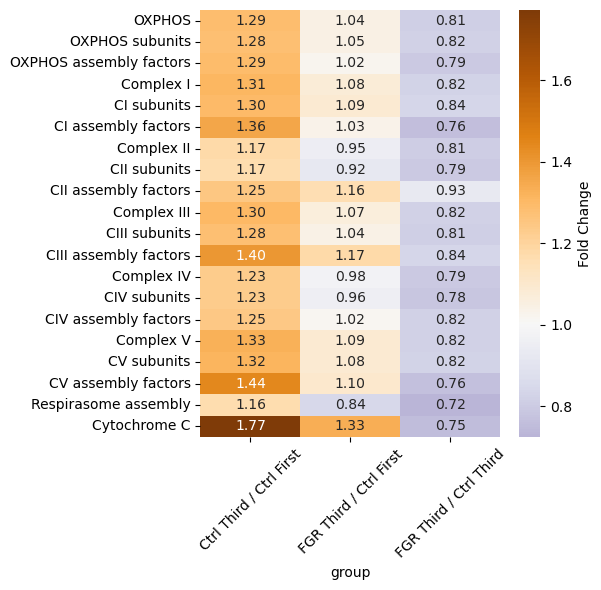

In [13]:
# Calculate all fold changes
all_fold_changes = []
for cell_type in ['Trophoblast']:
    t1_control = pathway_matrix.loc[f"{cell_type}_T1_Control"]
    t3_control = pathway_matrix.loc[f"{cell_type}_T3_Control"]
    t3_fgr = pathway_matrix.loc[f"{cell_type}_T3_FGR"]
    
    # Calculate fold changes
    fc_third_first = (t3_control / t1_control).replace([np.inf, -np.inf], np.nan)
    fc_fgr_control_t1 = (t3_fgr / t1_control).replace([np.inf, -np.inf], np.nan)
    fc_fgr_control_t3 = (t3_fgr / t3_control).replace([np.inf, -np.inf], np.nan)
    
    # Add to list with comparison labels
    all_fold_changes.extend([
        {'cell_type': cell_type, 'comparison': 'Ctrl Third / Ctrl First', **fc_third_first.to_dict()},
        {'cell_type': cell_type, 'comparison': 'FGR Third / Ctrl First', **fc_fgr_control_t1.to_dict()},
        {'cell_type': cell_type, 'comparison': 'FGR Third / Ctrl Third', **fc_fgr_control_t3.to_dict()}
    ])

# Create combined fold change DataFrame
fc_combined_df = pd.DataFrame(all_fold_changes)
fc_combined_df['group'] = fc_combined_df['comparison']
fc_matrix = fc_combined_df.set_index('group')[pathway_names]
fc_matrix.columns = fc_matrix.columns.str.replace('_', ' ')
fc_matrix.index = fc_matrix.index.str.replace('_', ' ')

# Create the side-by-side fold change heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(fc_matrix.T, 
            annot=True, 
            cmap='PuOr_r',
            center=1,
            cbar_kws={'label': 'Fold Change'},
            fmt='.2f')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("sp_FCheatmap.png", dpi=300, bbox_inches='tight')
plt.show()

## extra 

In [ ]:
# Function to get genes for each pathway
def get_pathway_genes(pathway_name):
    return adata.var_names[adata.var['MitoPathways'].apply(
        lambda x: any(pathway_name in pathway for pathway in x)
    )].tolist()

# Create expression matrix organized by pathway
pathway_expr_data = []
for cell_type in ['Trophoblast']:
    for Trimester in ['First', 'Third']:
        mask = (adata.obs['cell_type'] == cell_type) & (adata.obs['Trimester'] == Trimester)
        if mask.sum() > 0:
            row_data = {'cell_type': cell_type, 'Trimester': Trimester,
                       'group': f"{cell_type}_{Trimester}"}
            
            for pathway in pathway_names:
                pathway_genes = get_pathway_genes(pathway)
                if len(pathway_genes) > 0:
                    # Fix: Ensure mean calculation returns a scalar float
                    mean_expr = float(adata[mask, pathway_genes].X.mean())
                    row_data[pathway] = mean_expr
                else:
                    # If no genes found, set to NaN or 0
                    row_data[pathway] = np.nan
            
            pathway_expr_data.append(row_data)

pathway_df = pd.DataFrame(pathway_expr_data)
pathway_matrix = pathway_df.set_index('group')[pathway_names]

# Ensure all values are numeric
pathway_matrix = pathway_matrix.astype(float)

# Create annotated heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pathway_matrix.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdYlBu_r
            center=pathway_matrix.mean().mean(),
            cbar_kws={'label': 'Mean Expression'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Expression: First vs Third Trimester')
plt.ylabel('OXPHOS Subpathways')
plt.xlabel('Cell Type & Trimester')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

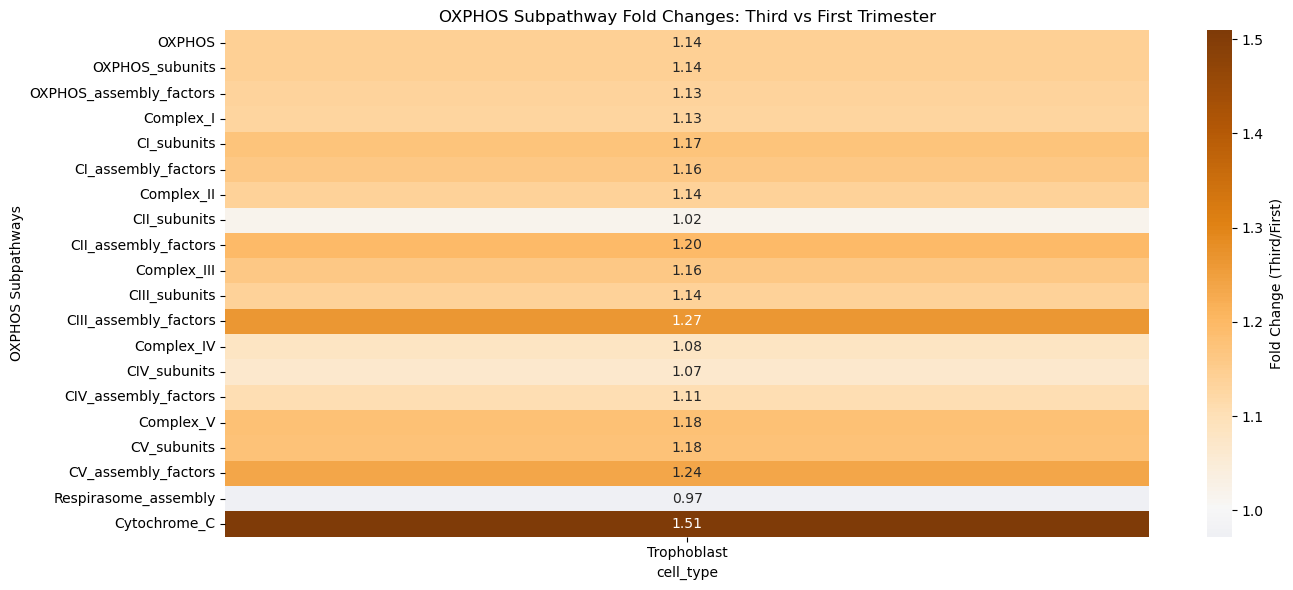

In [27]:
# Calculate fold changes (Third/First trimester) for each cell type
fold_changes = []

for cell_type in ['Trophoblast']:
    first_expr = pathway_matrix.loc[f"{cell_type}_First"]
    third_expr = pathway_matrix.loc[f"{cell_type}_Third"]
    
    fold_change = (third_expr / first_expr).replace([np.inf, -np.inf], np.nan)
    fold_changes.append({
        'cell_type': cell_type,
        **fold_change.to_dict()
    })

fc_df = pd.DataFrame(fold_changes).set_index('cell_type')

# Visualize fold changes
plt.figure(figsize=(14, 6))
sns.heatmap(fc_df.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdBu_r
            center=1,
            cbar_kws={'label': 'Fold Change (Third/First)'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Fold Changes: Third vs First Trimester')
plt.ylabel('OXPHOS Subpathways')
plt.tight_layout()

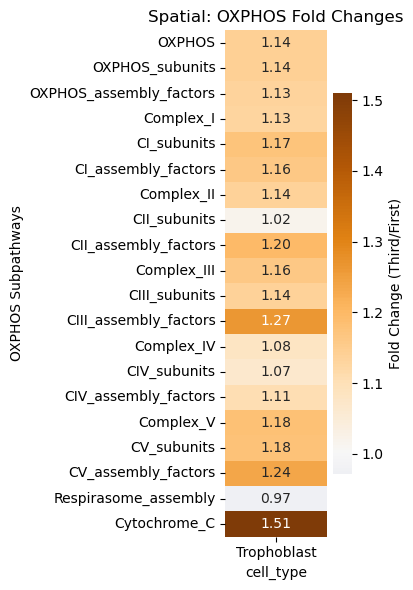

In [45]:
# Calculate fold changes (Third/First trimester) for each cell type
fold_changes = []

for cell_type in ['Trophoblast']:
    first_expr = pathway_matrix.loc[f"{cell_type}_First"]
    third_expr = pathway_matrix.loc[f"{cell_type}_Third"]
    
    fold_change = (third_expr / first_expr).replace([np.inf, -np.inf], np.nan)
    fold_changes.append({
        'cell_type': cell_type,
        **fold_change.to_dict()
    })

fc_df = pd.DataFrame(fold_changes).set_index('cell_type')

# Visualize fold changes
plt.figure(figsize=(4, 6))
sns.heatmap(fc_df.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdBu_r
            center=1,
            cbar_kws={'label': 'Fold Change (Third/First)'},
            fmt='.2f')
plt.title('Spatial: OXPHOS Fold Changes')
plt.ylabel('OXPHOS Subpathways')
plt.tight_layout()

Found 136 unique OXPHOS genes
Analyzing Trophoblast...


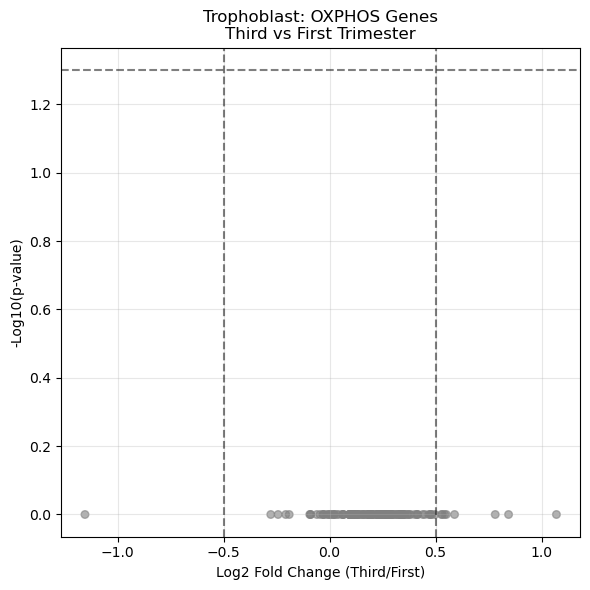


Summary of significant genes:
Trophoblast: 0 upregulated, 0 downregulated (p<0.05, |log2FC|>0.5)


In [29]:
# First, get all OXPHOS genes
oxphos_genes = []
for pathway in pathway_names:
    pathway_genes = get_pathway_genes(pathway)
    oxphos_genes.extend(pathway_genes)
oxphos_genes = list(set(oxphos_genes))  # Remove duplicates

print(f"Found {len(oxphos_genes)} unique OXPHOS genes")

# Perform differential expression analysis for each cell type
def perform_de_analysis(cell_type, genes_list):
    """Perform DE analysis comparing First vs Third trimester for a specific cell type"""
    
    # Get masks for first and third trimester
    first_mask = (adata.obs['cell_type'] == cell_type) & (adata.obs['Trimester'] == 'First')
    third_mask = (adata.obs['cell_type'] == cell_type) & (adata.obs['Trimester'] == 'Third')
    
    if first_mask.sum() == 0 or third_mask.sum() == 0:
        print(f"No cells found for {cell_type}")
        return None
    
    de_results = []
    
    for gene in genes_list:
        if gene in adata.var_names:
            # Get expression values
            first_expr = adata[first_mask, gene].X
            third_expr = adata[third_mask, gene].X
            
            # Convert to arrays if sparse
            if hasattr(first_expr, 'toarray'):
                first_expr = first_expr.toarray().flatten()
                third_expr = third_expr.toarray().flatten()
            else:
                first_expr = first_expr.flatten()
                third_expr = third_expr.flatten()
            
            # Calculate statistics
            mean_first = np.mean(first_expr)
            mean_third = np.mean(third_expr)
            log2fc = np.log2((mean_third + 1e-8) / (mean_first + 1e-8))
            
            # Perform t-test
            try:
                t_stat, p_value = stats.ttest_ind(third_expr, first_expr)
                if np.isnan(p_value):
                    p_value = 1.0
            except:
                p_value = 1.0
                t_stat = 0
            
            de_results.append({
                'gene': gene,
                'log2fc': log2fc,
                'p_value': p_value,
                'mean_first': mean_first,
                'mean_third': mean_third,
                't_stat': t_stat
            })
    
    return pd.DataFrame(de_results)

# Perform DE analysis for 'Trophoblast' cell type only
cell_types = ['Trophoblast']
de_results_all = {}

for cell_type in cell_types:
    print(f"Analyzing {cell_type}...")
    de_df = perform_de_analysis(cell_type, oxphos_genes)
    if de_df is not None:
        # Calculate -log10(p-value)
        de_df['neg_log10_pval'] = -np.log10(de_df['p_value'].clip(lower=1e-300))
        de_results_all[cell_type] = de_df

# Create volcano plot for 'Trophoblast'
fig, axes = plt.subplots(1, 1, figsize=(6, 6))  # Only one subplot now

cell_type = 'Trophoblast'
if cell_type in de_results_all:
    df = de_results_all[cell_type]
    
    # Define significance thresholds
    pval_threshold = 0.05
    fc_threshold = 0.5  # log2 fold change threshold
    
    # Color points based on significance
    colors = []
    for _, row in df.iterrows():
        if row['p_value'] < pval_threshold and abs(row['log2fc']) > fc_threshold:
            if row['log2fc'] > 0:
                colors.append('red')  # Upregulated in Third trimester
            else:
                colors.append('blue')  # Downregulated in Third trimester
        else:
            colors.append('gray')  # Not significant
    
    # Create volcano plot
    axes.scatter(df['log2fc'], df['neg_log10_pval'], 
                 c=colors, alpha=0.6, s=30)
    
    # Add threshold lines
    axes.axhline(y=-np.log10(pval_threshold), color='black', linestyle='--', alpha=0.5)
    axes.axvline(x=fc_threshold, color='black', linestyle='--', alpha=0.5)
    axes.axvline(x=-fc_threshold, color='black', linestyle='--', alpha=0.5)
    
    # Label significant genes (top 10 by p-value)
    sig_genes = df[(df['p_value'] < pval_threshold) & (abs(df['log2fc']) > fc_threshold)]
    if len(sig_genes) > 0:
        top_genes = sig_genes.nsmallest(10, 'p_value')
        for _, row in top_genes.iterrows():
            axes.annotate(row['gene'].split('.')[0], 
                          (row['log2fc'], row['neg_log10_pval']),
                          xytext=(5, 5), textcoords='offset points',
                          fontsize=8, alpha=0.8)
    
    axes.set_xlabel('Log2 Fold Change (Third/First)')
    axes.set_ylabel('-Log10(p-value)')
    axes.set_title(f'{cell_type}: OXPHOS Genes\nThird vs First Trimester')
    axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary of significant genes:")
for cell_type in cell_types:
    if cell_type in de_results_all:
        df = de_results_all[cell_type]
        sig_up = ((df['p_value'] < 0.05) & (df['log2fc'] > 0.5)).sum()
        sig_down = ((df['p_value'] < 0.05) & (df['log2fc'] < -0.5)).sum()
        print(f"{cell_type}: {sig_up} upregulated, {sig_down} downregulated (p<0.05, |log2FC|>0.5)")

#### Third: Control vs FGR ####

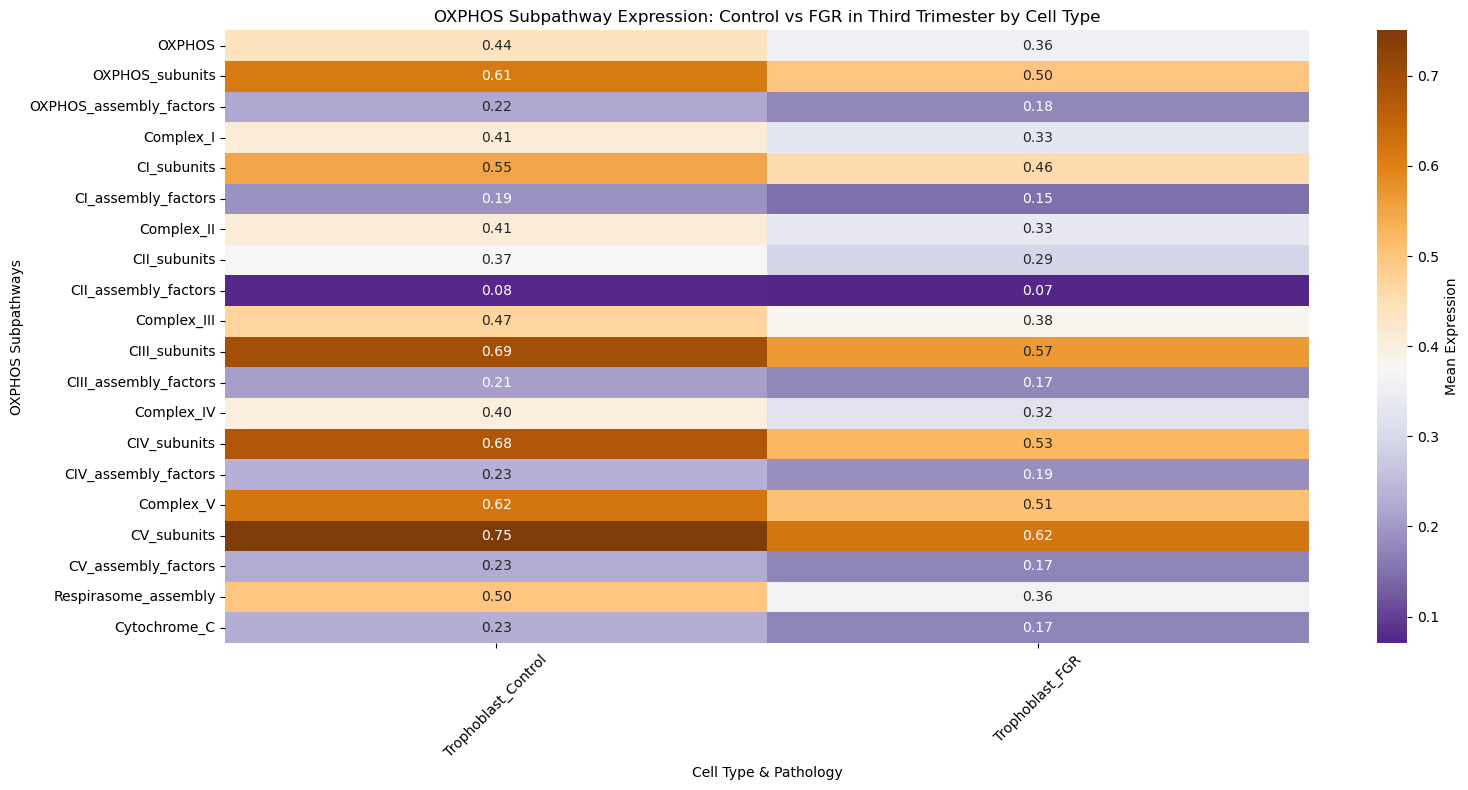

In [30]:
# Function to get genes for each pathway
def get_pathway_genes(pathway_name):
    return adata.var_names[adata.var['MitoPathways'].apply(
        lambda x: any(pathway_name in pathway for pathway in x)
    )].tolist()

# Create expression matrix organized by pathway
pathway_expr_data = []
for cell_type in ['Trophoblast']:
     for pathology in ['Control', 'FGR']:
        mask = (adata.obs['cell_type'] == cell_type) & (adata.obs['Trimester'] == Trimester) & (adata.obs['Pathology'] == pathology)
        if mask.sum() > 0:
            row_data = {'cell_type': cell_type, 'Pathology': pathology,
                       'group': f"{cell_type}_{pathology}"}
            
            for pathway in pathway_names:
                pathway_genes = get_pathway_genes(pathway)
                if len(pathway_genes) > 0:
                    # Fix: Ensure mean calculation returns a scalar float
                    mean_expr = float(adata[mask, pathway_genes].X.mean())
                    row_data[pathway] = mean_expr
                else:
                    # If no genes found, set to NaN or 0
                    row_data[pathway] = np.nan
            
            pathway_expr_data.append(row_data)

pathway_df = pd.DataFrame(pathway_expr_data)
pathway_matrix = pathway_df.set_index('group')[pathway_names]

# Ensure all values are numeric
pathway_matrix = pathway_matrix.astype(float)

# Create annotated heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pathway_matrix.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdYlBu_r
            center=pathway_matrix.mean().mean(),
            cbar_kws={'label': 'Mean Expression'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Expression: Control vs FGR in Third Trimester by Cell Type')
plt.ylabel('OXPHOS Subpathways')
plt.xlabel('Cell Type & Pathology')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

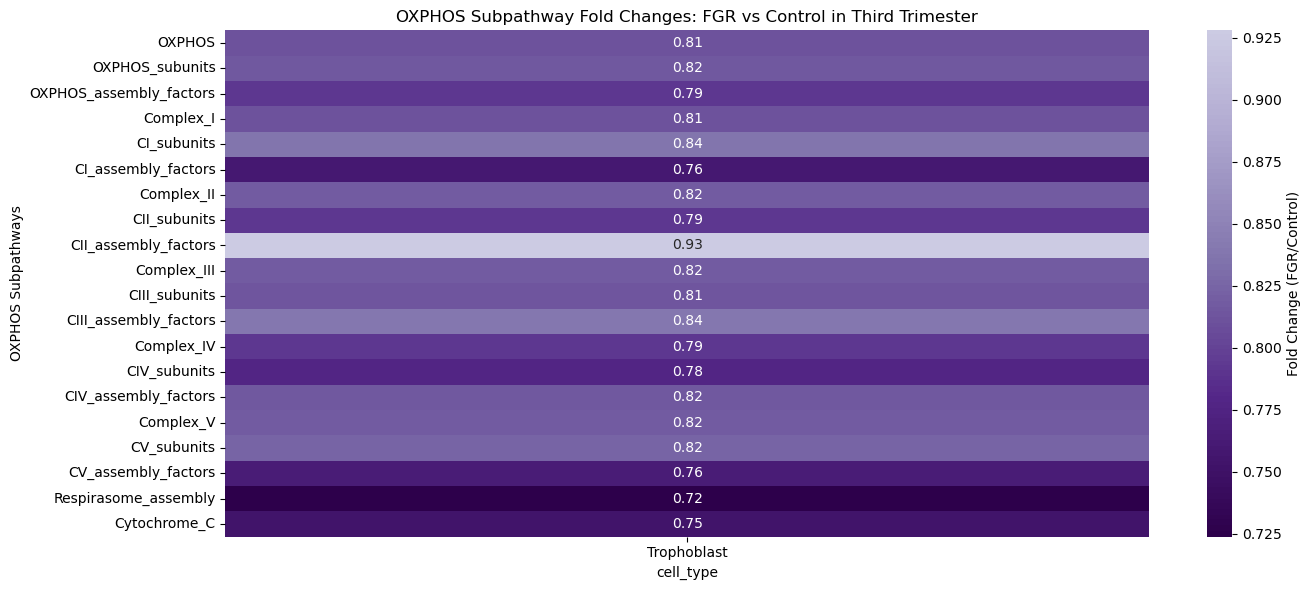

In [31]:
# Calculate fold changes (Third/First trimester) for each cell type
fold_changes = []

for cell_type in ['Trophoblast']:
    control_expr = pathway_matrix.loc[f"{cell_type}_Control"]
    fgr_expr = pathway_matrix.loc[f"{cell_type}_FGR"]
    
    fold_change = (fgr_expr / control_expr).replace([np.inf, -np.inf], np.nan)
    fold_changes.append({
        'cell_type': cell_type,
        **fold_change.to_dict()
    })

fc_df = pd.DataFrame(fold_changes).set_index('cell_type')

# Visualize fold changes
plt.figure(figsize=(14, 6))
sns.heatmap(fc_df.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdBu_r
            center=1,
            cbar_kws={'label': 'Fold Change (FGR/Control)'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Fold Changes: FGR vs Control in Third Trimester')
plt.ylabel('OXPHOS Subpathways')
plt.tight_layout()

In [32]:
#### First vs FGR ####

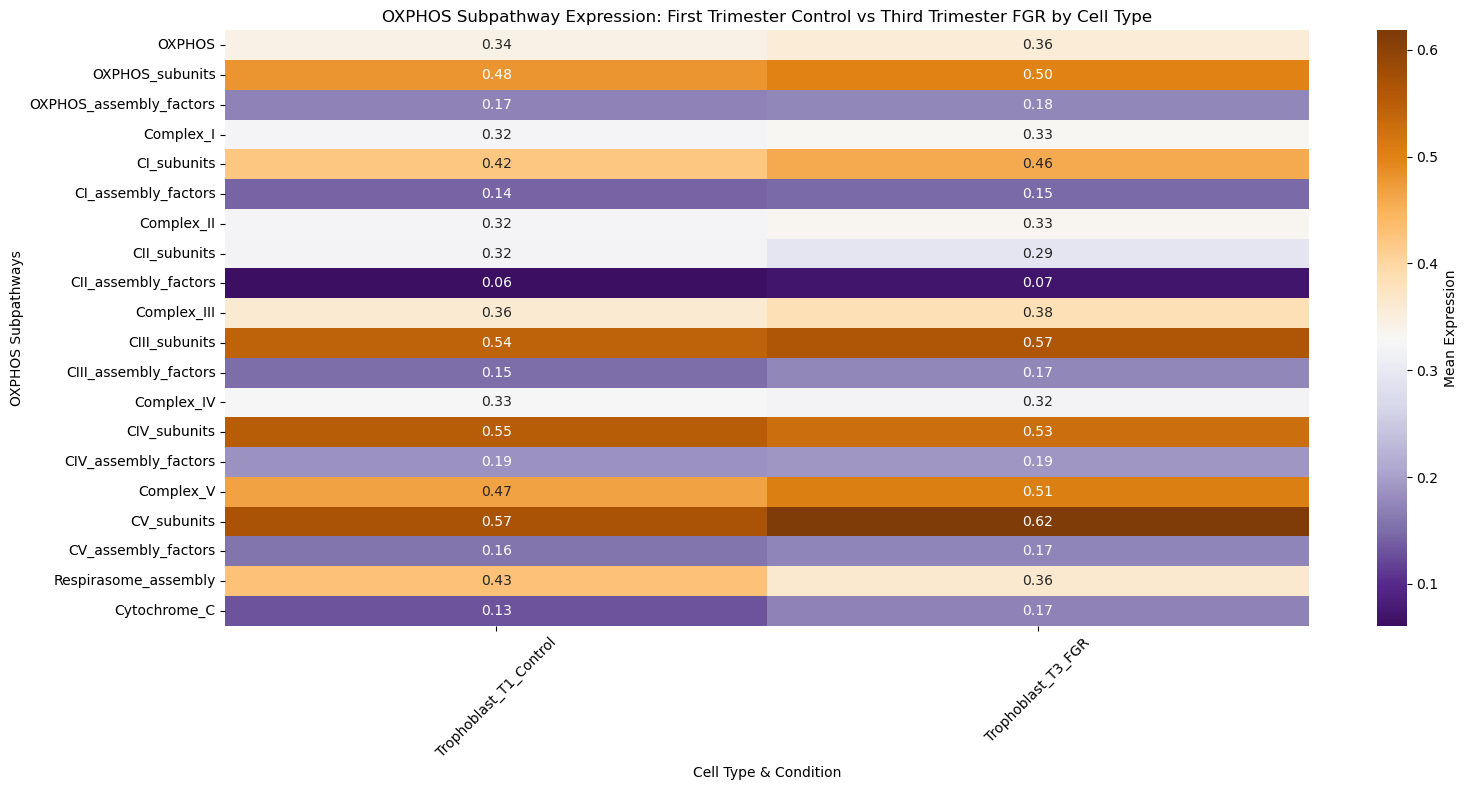

In [33]:
# Function to get genes for each pathway
def get_pathway_genes(pathway_name):
    return adata.var_names[adata.var['MitoPathways'].apply(
        lambda x: any(pathway_name in pathway for pathway in x)
    )].tolist()

# Create expression matrix organized by pathway
pathway_expr_data = []
for cell_type in ['Trophoblast']:
    # First trimester control
    mask_t1_control = (adata.obs['cell_type'] == cell_type) & \
                      (adata.obs['Trimester'] == 'First') & \
                      (adata.obs['Pathology'] == 'Control')
    
    # Third trimester FGR
    mask_t3_fgr = (adata.obs['cell_type'] == cell_type) & \
                  (adata.obs['Trimester'] == 'Third') & \
                  (adata.obs['Pathology'] == 'FGR')
    
    # Process first trimester control
    if mask_t1_control.sum() > 0:
        row_data = {
            'cell_type': cell_type,
            'condition': 'T1_Control',
            'group': f"{cell_type}_T1_Control"
        }
        for pathway in pathway_names:
            pathway_genes = get_pathway_genes(pathway)
            if len(pathway_genes) > 0:
                # Fix: Ensure mean calculation returns a scalar float
                mean_expr = float(adata[mask_t1_control, pathway_genes].X.mean())
                row_data[pathway] = mean_expr
            else:
                # If no genes found, set to NaN or 0
                row_data[pathway] = np.nan
        pathway_expr_data.append(row_data)

    # Process third trimester FGR
    if mask_t3_fgr.sum() > 0:
        row_data = {
            'cell_type': cell_type,
            'condition': 'T3_FGR',
            'group': f"{cell_type}_T3_FGR"
        }
        for pathway in pathway_names:
            pathway_genes = get_pathway_genes(pathway)
            if len(pathway_genes) > 0:
                # Fix: Ensure mean calculation returns a scalar float
                mean_expr = float(adata[mask_t3_fgr, pathway_genes].X.mean())
                row_data[pathway] = mean_expr
            else:
                # If no genes found, set to NaN or 0
                row_data[pathway] = np.nan
        pathway_expr_data.append(row_data)

pathway_df = pd.DataFrame(pathway_expr_data)
pathway_matrix = pathway_df.set_index('group')[pathway_names]

# Ensure all values are numeric
pathway_matrix = pathway_matrix.astype(float)

# Create annotated heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(pathway_matrix.T, 
            annot=True, 
            cmap='PuOr_r', # PuOr_r; RdYlBu_r
            center=pathway_matrix.mean().mean(),
            cbar_kws={'label': 'Mean Expression'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Expression: First Trimester Control vs Third Trimester FGR by Cell Type')
plt.ylabel('OXPHOS Subpathways')
plt.xlabel('Cell Type & Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

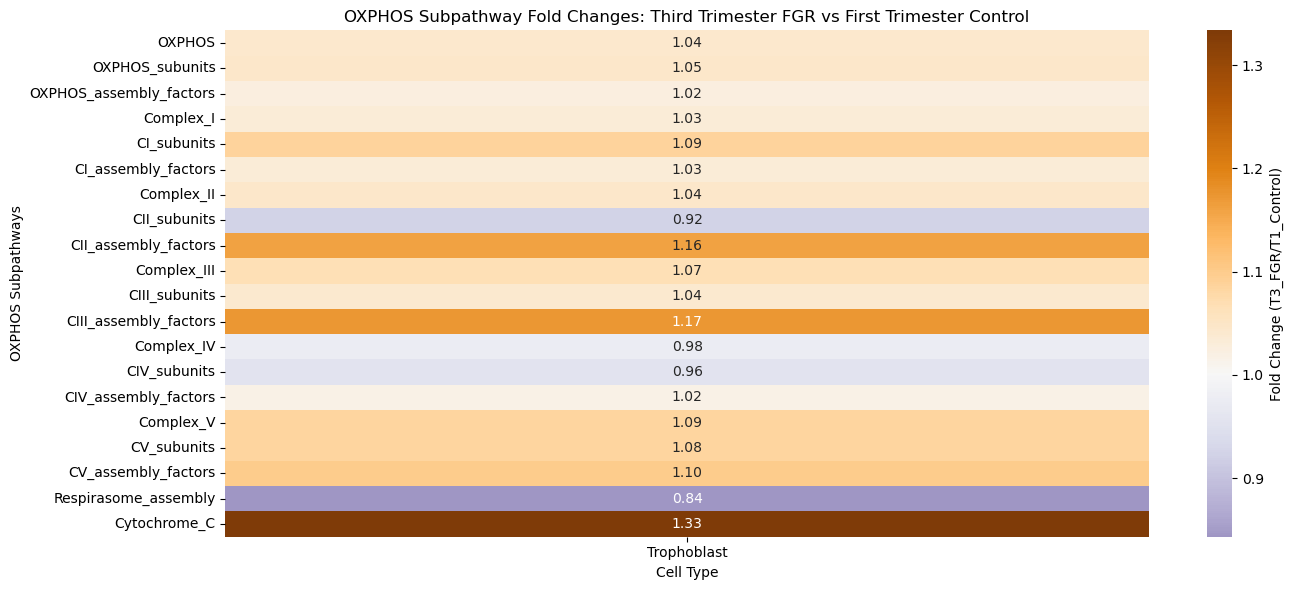

In [35]:
# Calculate fold changes (T3_FGR/T1_Control) for each cell type
fold_changes = []
for cell_type in ['Trophoblast']:
    t1_control_expr = pathway_matrix.loc[f"{cell_type}_T1_Control"]
    t3_fgr_expr = pathway_matrix.loc[f"{cell_type}_T3_FGR"]
    
    fold_change = (t3_fgr_expr / t1_control_expr).replace([np.inf, -np.inf], np.nan)
    fold_changes.append({
        'cell_type': cell_type,
        **fold_change.to_dict()
    })

fc_df = pd.DataFrame(fold_changes).set_index('cell_type')

# Visualize fold changes
plt.figure(figsize=(14, 6))
sns.heatmap(fc_df.T, 
            annot=True, 
            cmap='PuOr_r', 
            center=1,
            cbar_kws={'label': 'Fold Change (T3_FGR/T1_Control)'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Fold Changes: Third Trimester FGR vs First Trimester Control')
plt.ylabel('OXPHOS Subpathways')
plt.xlabel('Cell Type')
plt.tight_layout()
plt.show()

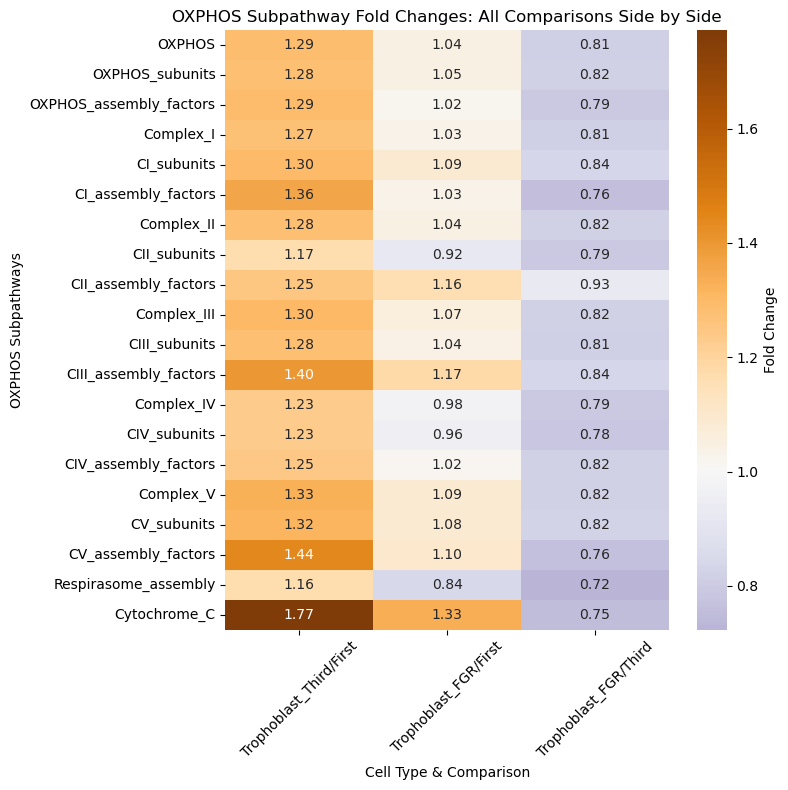

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get genes for each pathway (keep your existing function)
def get_pathway_genes(pathway_name):
    return adata.var_names[adata.var['MitoPathways'].apply(
        lambda x: any(pathway_name in pathway for pathway in x)
    )].tolist()

# Create expression matrix for all conditions
pathway_expr_data = []
for cell_type in ['Trophoblast']:
    conditions = [
        ('First', 'Control', 'T1_Control'),
        ('Third', 'Control', 'T3_Control'),
        ('Third', 'FGR', 'T3_FGR')
    ]
    
    for trimester, pathology, condition_name in conditions:
        mask = (adata.obs['cell_type'] == cell_type) & \
               (adata.obs['Trimester'] == trimester) & \
               (adata.obs['Pathology'] == pathology)
        
        if mask.sum() > 0:
            row_data = {
                'cell_type': cell_type,
                'condition': condition_name,
                'group': f"{cell_type}_{condition_name}"
            }
            
            for pathway in pathway_names:
                pathway_genes = get_pathway_genes(pathway)
                if len(pathway_genes) > 0:
                    mean_expr = float(adata[mask, pathway_genes].X.mean())
                    row_data[pathway] = mean_expr
                else:
                    row_data[pathway] = np.nan
            
            pathway_expr_data.append(row_data)

# Create the pathway matrix
pathway_df = pd.DataFrame(pathway_expr_data)
pathway_matrix = pathway_df.set_index('group')[pathway_names]
pathway_matrix = pathway_matrix.astype(float)

# Calculate all fold changes
all_fold_changes = []
for cell_type in ['Trophoblast']:
    t1_control = pathway_matrix.loc[f"{cell_type}_T1_Control"]
    t3_control = pathway_matrix.loc[f"{cell_type}_T3_Control"]
    t3_fgr = pathway_matrix.loc[f"{cell_type}_T3_FGR"]
    
    # Calculate fold changes
    fc_third_first = (t3_control / t1_control).replace([np.inf, -np.inf], np.nan)
    fc_fgr_control_t1 = (t3_fgr / t1_control).replace([np.inf, -np.inf], np.nan)
    fc_fgr_control_t3 = (t3_fgr / t3_control).replace([np.inf, -np.inf], np.nan)
    
    # Add to list with comparison labels
    all_fold_changes.extend([
        {'cell_type': cell_type, 'comparison': 'Third/First', **fc_third_first.to_dict()},
        {'cell_type': cell_type, 'comparison': 'FGR/First', **fc_fgr_control_t1.to_dict()},
        {'cell_type': cell_type, 'comparison': 'FGR/Third', **fc_fgr_control_t3.to_dict()}
    ])

# Create combined fold change DataFrame
fc_combined_df = pd.DataFrame(all_fold_changes)
fc_combined_df['group'] = fc_combined_df['cell_type'] + '_' + fc_combined_df['comparison']
fc_matrix = fc_combined_df.set_index('group')[pathway_names]

# Create the side-by-side fold change heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(fc_matrix.T, 
            annot=True, 
            cmap='PuOr_r',
            center=1,
            cbar_kws={'label': 'Fold Change'},
            fmt='.2f')
plt.title('OXPHOS Subpathway Fold Changes: All Comparisons Side by Side')
plt.ylabel('OXPHOS Subpathways')
plt.xlabel('Cell Type & Comparison')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# # Optional: Create separate subplots for better visualization
# fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
# comparisons = ['Third/First', 'FGR/First', 'FGR/Third']

# for i, comparison in enumerate(comparisons):
#     comparison_data = fc_matrix.loc[fc_matrix.index.str.contains(comparison)]
    
#     sns.heatmap(comparison_data.T, 
#                 annot=True, 
#                 cmap='PuOr_r',
#                 center=1,
#                 cbar_kws={'label': 'Fold Change'},
#                 fmt='.2f',
#                 ax=axes[i])
#     axes[i].set_title(f'{comparison}')
#     axes[i].set_xlabel('Cell Type')
#     if i == 0:
#         axes[i].set_ylabel('OXPHOS Subpathways')
#     else:
#         axes[i].set_ylabel('')

# plt.tight_layout()
# plt.show()